In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import normalize

%matplotlib inline

In [2]:
# Load data
game_info = np.asarray(pd.read_csv('data/CFB2016_scores.csv', header = None))
team_names = pd.read_csv('data/TeamNames.txt', sep = "\n", header = None)
num_teams = len(team_names)

In [3]:
# Initialize Markov Matrix with 0s
M_hat = np.zeros([num_teams, num_teams])

In [4]:
# Create the unnormalized Markov transition Matrix
for i in range(len(game_info)):
    team_a = game_info[i][0]-1
    team_b = game_info[i][2]-1
    points_a = game_info[i][1]
    points_b = game_info[i][3]
    M_hat[team_a][team_a] += int(points_a > points_b) + points_a/(points_a+points_b)
    M_hat[team_b][team_b] += int(points_b > points_a) + points_b/(points_a+points_b)
    M_hat[team_a][team_b] += int(points_b > points_a) + points_b/(points_a+points_b)
    M_hat[team_b][team_a] += int(points_a > points_b) + points_a/(points_a+points_b)

In [5]:
# Normalize the Markove Matrix
M = normalize(M_hat, norm='l1', axis=1)

In [6]:
#w_0 is the uniform distribution (Step 0)
w_0 = np.full((num_teams), 1/num_teams)

In [7]:
def stationary_distribution(M):
    """Compute the stationary distribution.
    State we'd arrive at if we project an infinite number of steps out.
    Lim t-> infinity w_t

    Parameters
    ----------
    M : array-like, shape = N X N
        Markov transition matrix
        
    Returns
    ----------
    u_norm : array-like, shape = 1 X N
        the stationary distribution
    """ 
    eigen_vals, eigen_vecs = np.linalg.eig(M.T)
    sorted_index = eigen_vals.argsort()[::-1]   
    eigen_vecs = eigen_vecs[:, sorted_index]
    u = eigen_vecs[:, 0]
    u_norm = u/np.sum(u)
    return u_norm

In [8]:
def state_distribution(M, initial_state, step, norm = False):
    """Compute the state distribution.
    The state we'll be in at step t+1

    Parameters
    ----------
    M : array-like, shape = N X N
        Markov transition matrix
        
    initial_state : array-like, shape = 1 X N
        Initial state (should be uniform)
        
    step : Int
        Number of steps
        
    norm : Boolean
        Specify whether to calculate stationary distribution and return norms
    
    Returns
    ----------
    w_t : array-like, shape = 1 X N
        State vector at step t
        
    norms : list[float]
        Default is None, otherwise list of differences
        between the stationary and state distribution at each step
    """ 
    w_t = np.matmul(initial_state, M)

    if norm:
        norms = []
        w_inf = stationary_distribution(M)
        for i in range(step):
            w_t = np.matmul(w_t, M)
            norms.append(np.linalg.norm((w_t - w_inf), ord=1))
        return w_t, norms
    
    for i in range(step):
        w_t = np.matmul(w_t, M)
        
    return w_t

In [9]:
def rank_teams(state_vector, team_names, num_ranks):
    """ Rank teams given the current state

    Parameters
    ----------
    state_vector : array-like, shape = 1 X N
        Current state of markov walk
        
    team_names : array-like
        List of team names
        
    num_ranks : Integer
        Number of teams to return
    
    Returns
    ----------
    top_info : array-like
        Top teams and value
        
    norms : list[float]
        Default is None, otherwise list of differences
        between the stationary and state distribution at each step
    """
    top = pd.DataFrame(state_vector).sort_values(by = 0, ascending = False)[:num_ranks]
    top = top.assign(Team = team_names.iloc[top.index])
    top.rename(columns = {0:'Value'}, inplace = True)
    top.reset_index(inplace = True, drop = True)
    top.index += 1
    top_info = top[['Team', 'Value']]
    return top_info

In [10]:
# Rank Teams after 10 steps
w_ten = state_distribution(M, w_0, 10)
rank_teams(w_ten, team_names, 25)

,Team,Value
1,Mary Hardin-Baylor,0.015706
2,NW Missouri St,0.014039
3,Alabama,0.013245
4,Clemson,0.011824
5,UW-Oshkosh,0.010527
6,UW-Whitewater,0.008598
7,St Thomas,0.008492
8,St Francis IN,0.008370
9,Mount Union,0.008050
10,James Madison,0.007648


In [11]:
# Rank Teams after 100 steps
w_hundred = state_distribution(M, w_0, 100)
rank_teams(w_hundred, team_names, 25)

,Team,Value
1,NW Missouri St,0.038343
2,Alabama,0.033447
3,Clemson,0.033072
4,Mary Hardin-Baylor,0.030844
5,UW-Oshkosh,0.016809
6,UW-Whitewater,0.012133
7,Florida St,0.010469
8,Grand Valley St,0.010272
9,John Carroll,0.010221
10,Ohio State,0.009964


In [12]:
# Rank Teams after 100 steps
w_thousand = state_distribution(M, w_0, 1000)
rank_teams(w_thousand, team_names, 25)

,Team,Value
1,Alabama,0.060731
2,Clemson,0.060420
3,NW Missouri St,0.030476
4,Florida St,0.018817
5,Ohio State,0.017987
6,Washington,0.015892
7,Virginia Tech,0.015827
8,Michigan,0.014830
9,Pittsburgh,0.014654
10,Oklahoma,0.014393


In [13]:
# Rank Teams after 10000 steps
w_tenthousand, norms = state_distribution(M, w_0, 10000, norm = True)
rank_teams(w_tenthousand, team_names, 25)

,Team,Value
1,Alabama,0.067282
2,Clemson,0.066983
3,Florida St,0.020835
4,Ohio State,0.019922
5,Washington,0.017579
6,Virginia Tech,0.017524
7,Michigan,0.016426
8,NW Missouri St,0.016342
9,Pittsburgh,0.016235
10,Oklahoma,0.015922


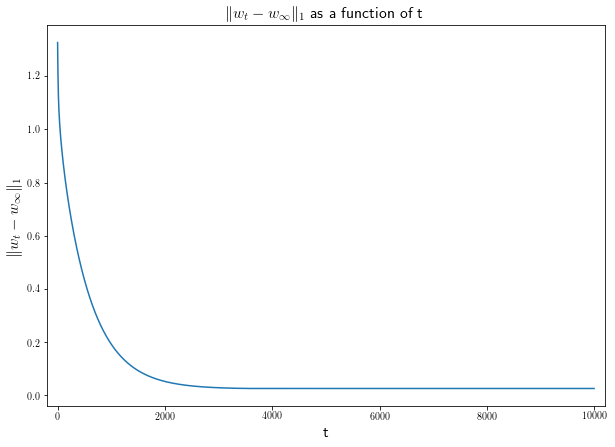

In [14]:
# The state distribution approaches the stationary distribution after around 2500 steps
rc('text', usetex=True)
plt.figure(figsize=(10,7))
plt.plot(range(10000), norms)
plt.xlim([-200,10200])
plt.title(r'$\|w_t - w_{\infty}\|_1$ as a function of t ', fontsize=16)
plt.xlabel('t', fontsize = 16)
plt.ylabel(r'\|w_t - w_{\infty}\|_1', fontsize=16);